In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Union, Optional
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose


sns.set_style('darkgrid')

ameriflux = pd.read_csv('../../AMF_PE-QFR_FLUXNET_FULLSET_2018-2019_3-5/AMF_PE-QFR_FLUXNET_FULLSET_HH_2018-2019_3-5.csv',na_values=-9999)
gpp_smap = pd.read_csv('../Amazonia_peruana/freq_diaria_smap/gpp_mean.csv',header=None)
rh_smap = pd.read_csv('../Amazonia_peruana/freq_diaria_smap/rh_mean.csv',header=None)
nee_smap = pd.read_csv('../Amazonia_peruana/freq_diaria_smap/nee_mean.csv',header=None)


def dateindex(df):
    df[0] = df[0].str.extract(r'(?:[^_]*_){4}(.*?)(?=T)')
    df = df.drop([1,2,3,4],axis=1)
    df.index = df[0].apply(lambda x: datetime.strptime(x,"%Y%m%d"))
    df = df.drop(0,axis=1)
    return df

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
def reg_graph_subplot(x, y, data, sct_size=None, s=10, title='', legend_visibility=True, legend_title='', xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False, reg_from_start=False, offset_txt_x=0.15, offset_txt_y=2.25, num_rows=1, num_cols=1, subplot_num=1, axes=None):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico BASEADO em uma coluna do dataframe
    # s = tamanho do scatter no gráfico BASEADO em um NUMERO
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y
    # num_rows = número de linhas de subplots
    # num_cols = número de colunas de subplots
    # subplot_num = número do subplot atual
    # axes = array de eixos para os subplots

    sns.set_style('darkgrid')

    if axes is None:
        f, ax = plt.subplots(num_rows, num_cols, figsize=(12, 5))
        ax = ax.flatten()
        ax = ax[subplot_num - 1]
    else:
        ax = axes[subplot_num - 1]

    sns.scatterplot(x=data[x], y=data[y], data=data, size=sct_size, s=s, ax=ax)

    rng = np.random.default_rng(1234)  # seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)
    fitted_reg = lr.fit(data[[x]], data[[y]])

    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_]  # Prevenindo erros

    r2_score = fitted_reg.score(data[[x]], data[[y]])  # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100)  # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0]  # função y=ax + b para representar a reta criada

    if reg_from_start:

        if (data[x].min() < 0) and (abs(data[x].min()) > data[y].max()):  # Para valores data[x] negativos

            x_reg_line = rng.uniform(data[x].min() * 2, 0.0, size=10000)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[y].min() < 0) and (abs(data[y].min()) > data[x].max()):  # Para valores data[y] negativos

            x_reg_line = rng.uniform(data[y].min() * 2, 0.0, size=10000)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[x].max() > data[y].max()):

            x_reg_line = rng.uniform(0.0, data[x].max() * 2, size=10000)

        else:

            x_reg_line = rng.uniform(0.0, data[y].max() * 2, size=10000)

        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0]  # função y=ax + b para representar a reta criada

    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  # eixo x do texto

    ax.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0], 4)}x + {round(fitted_reg.intercept_[0], 4)}',
            fontsize=12, ha='center', va='center', color='blue')  # Texto da reta Azul
    ax.text(text_coord_x, offset_txt_y - (offset_txt_y * 0.3), f'R²:{round(r2_score, 4)}', fontsize=12, ha='center',
            va='center', color='blue')  # Texto r²

    ax.set_ylim((0, (data[y].max() + (data[y].max() / 2))))  # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + data[x].max() / 2))  # tamanho limite do plot no eixo x
    ax.plot(x_reg_line, y_reg_line[0])  # reta de regressão

    if ativar_grafico_yx:
        y_x = rng.uniform(0, 1000, size=1000)  # gerando 1000 valores aleatórios
        ax.plot(y_x, y_x, 'k--')  # reta y=x

    if legend_title:
        ax.legend(title=legend_title, loc='upper left').set_visible(legend_visibility)  # legenda no canto superior esquerdo

    ax.set_title(title)  # Título do gráfico
    ax.set_xlabel(xlabel)  # Título do eixo X
    ax.set_ylabel(ylabel)  # Título do eixo y

    return ax

ameriflux['TIMESTAMP_START'] = ameriflux['TIMESTAMP_START'].apply(lambda x: datetime.strptime(f'{x}', "%Y%m%d%H%M"))
ameriflux.index = ameriflux['TIMESTAMP_START']
ameriflux = ameriflux.drop(['TIMESTAMP_START','TIMESTAMP_END'],axis=1)

data = ameriflux[['NEE_VUT_MEAN','GPP_DT_VUT_MEAN','RECO_DT_VUT_MEAN']]

rh_data = dateindex(rh_smap)
gpp_data = dateindex(gpp_smap)
nee_data = dateindex(nee_smap)

In [16]:
def to_kgC(x):
    """Retorna valores convertidos para kg C m² s"""
    umol2mol = 1e-06
    Cmol = 0.012011
    minutesinseconds = 1800
    #days2seconds = 86400
    kg2g = 1000 # Precisamos em kg, não em g, por isso não multipliquei por 1000
    
    return x * umol2mol * Cmol * minutesinseconds * kg2g # cálculo dado pelo professor
  

def Gpp_Horario(serie_gpp:pd.Series):   
    return serie_gpp.between_time('07:00', '19:00').sum()


def Reco_Horario(serie_reco:pd.Series):   
    return serie_reco.between_time('20:00', '06:00').sum()

def Nee(serie_nee:pd.Series):   
    return serie_nee.sum()

    

def create_npp_data(npp_df:pd.Series,dataframe:pd.DataFrame,var:List[Union[str, str,str]]):
    for i in range(len(npp_df.index)):
        """Faz um looping em cada data para retornar os valores de npp desejados"""

        date = pd.to_datetime(npp_df.index[i].date()).strftime("%Y/%m/%d") # Transforma os index em uma data YY/MM/DD

        gpp_diario = dataframe[f'{var[1]}'][date].between_time('07:00', '19:00').sum() # dia 1,2,3,...
        reco_diario = dataframe[f'{var[2]}'][date].between_time('20:00', '06:00').sum()

        npp_diario = gpp_diario - reco_diario # GPP - RECO

        npp_df.loc[date,'Npp'] = npp_diario # Colocando no dataframe npp_df

    npp_df['Npp'] = npp_df['Npp'].apply(to_kgC) # Aplicando transformação para kg

    return npp_df

def create_flux_data(data_df:pd.Series,dataframe:pd.DataFrame,var:List[Union[str, str]]):
    
    var_names = {
        'Gpp':Gpp_Horario,
        'Nee':Nee,
        'Reco':Reco_Horario
    }
    
    for i in range(len(data_df.index)): # dia 1,2,3,...

        """Faz um looping em cada data para retornar os valores desejados"""

        date = pd.to_datetime(data_df.index[i].date()).strftime("%Y/%m/%d") # Transforma os index em uma data YY/MM/DD

        var_alvo = dataframe[f'{var[1]}'][date]
        
        var_alvo = var_names.get(f'{var[0]}')(var_alvo)

        data_df.loc[date,f'{var[0]}'] = var_alvo # Colocando no dataframe

    data_df[f'{var[0]}'] = data_df[f'{var[0]}'].apply(to_kgC) # Aplicando transformação para g

    return data_df


def process_variable_data(dataframe:pd.DataFrame,var:List[Union[str, str, Optional[str]]]):
    
    # var[0] = nome da variável alvo
    # var[1] = nome da coluna no dataframe referente à variável alvo
    # var[2] = nome da coluna no dataframe referente à variável alvo (OBRIGATORIO caso precise do NPP)
    
    var_names = {
        'Npp':create_npp_data,
        'Gpp':create_flux_data,
        'Nee':create_flux_data,
        'Reco':create_flux_data
    }
    
    data_df = pd.DataFrame(index=dataframe.resample('D').sum().index) # index = datas do dataframe (DADOS NÃO SÃO PUXADOS)
    
    data_df[f'{var[0]}'] = pd.Series(dtype='float') # Cria uma coluna com o nome da variável alvo
    
    data_df = var_names.get(f'{var[0]}')(data_df,dataframe,var)
    
    return data_df

Npp_ameriflux = process_variable_data(data,['Npp','GPP_DT_VUT_MEAN','RECO_DT_VUT_MEAN'])
gpp_ameriflux = process_variable_data(data,['Gpp','GPP_DT_VUT_MEAN'])
reco_ameriflux = process_variable_data(data,['Reco','RECO_DT_VUT_MEAN'])
nee_ameriflux = process_variable_data(data,['Nee','NEE_VUT_MEAN'])

## GPP TORRE X SMAP

,Ameriflux GPP,Smap GPP
Ameriflux GPP,1.000000,0.060384
Smap GPP,0.060384,1.000000


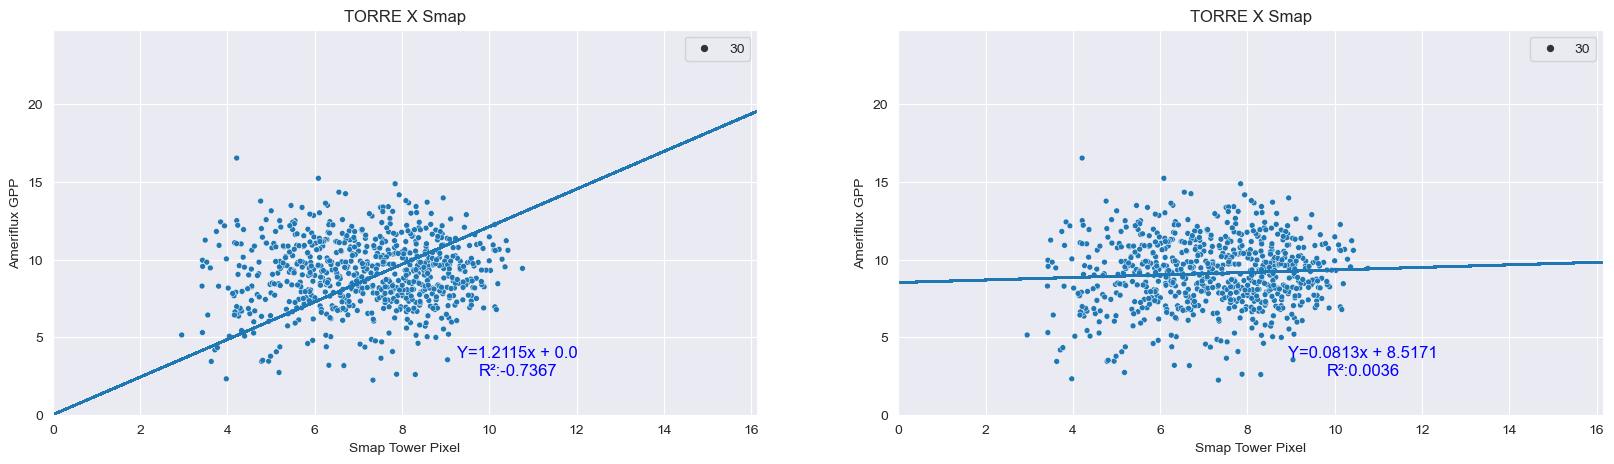

In [17]:
gpp_formated = gpp_data[9]['2018':'2019']
data = pd.concat([gpp_ameriflux['Gpp'],gpp_formated],axis=1).interpolate('time')
data = data.rename({'Gpp':'Ameriflux GPP',9:'Smap GPP'},axis=1)


fig, ax = plt.subplots(1,2, figsize=(20, 5))

eixo_x = 'Smap GPP'
eixo_y = 'Ameriflux GPP'

xlabel = 'Smap Tower Pixel'
ylabel = 'Ameriflux GPP'

title = 'TORRE X Smap'

corr = data.corr().copy()

reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.01,offset_txt_y=4,axes=ax,subplot_num=1,fit_intercept=False)
reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.01,offset_txt_y=4,axes=ax,subplot_num=2,fit_intercept=True)
corr

,Ameriflux GPP,Smap GPP
Ameriflux GPP,1.000000,0.060384
Smap GPP,0.060384,1.000000


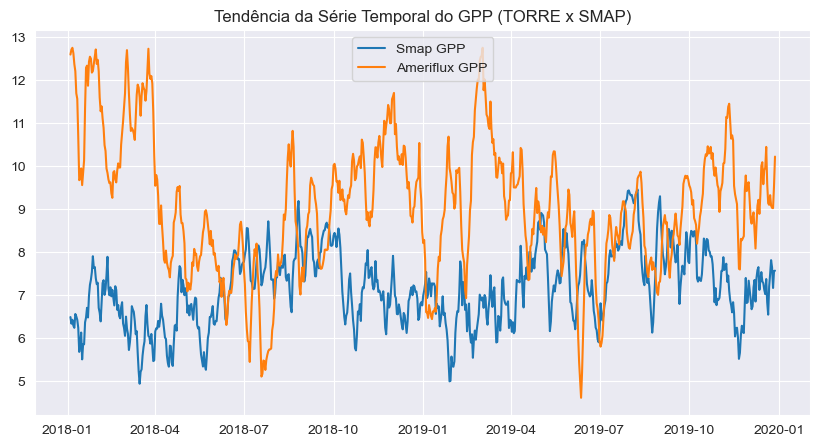

In [18]:
gpp_calculado_decomponsicao = seasonal_decompose(data['Smap GPP'])
gpp_calculado2_decomponsicao = seasonal_decompose(data['Ameriflux GPP'])

plt.figure(figsize=(10,5))
plt.plot(gpp_calculado_decomponsicao.trend)
plt.plot(gpp_calculado2_decomponsicao.trend)
plt.title("Tendência da Série Temporal do GPP (TORRE x SMAP)")
plt.legend(['Smap GPP','Ameriflux GPP'],loc='upper center').set_visible(True)

data.corr()

## NPP TORRE X SMAP

,Smap NPP,Ameriflux NPP
Smap NPP,1.000000,0.094304
Ameriflux NPP,0.094304,1.000000


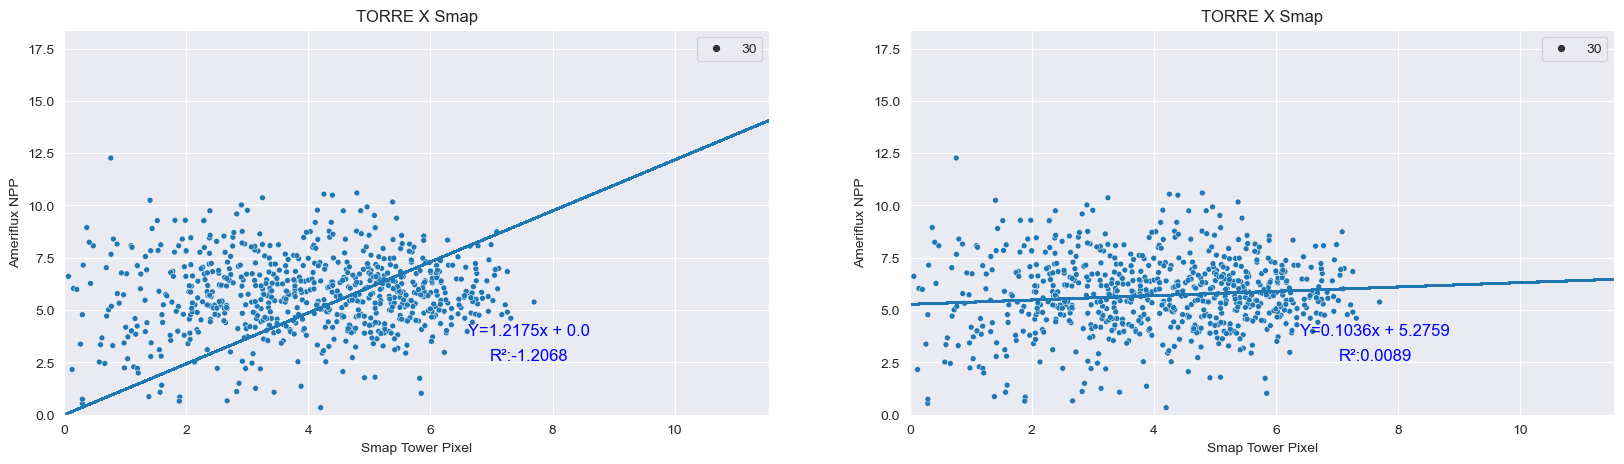

In [19]:
npp_data = pd.concat([(gpp_data[9] - rh_data[9])['2018':'2019'],Npp_ameriflux['Npp']],axis=1).interpolate('time')
npp_data = npp_data.rename({'Npp':'Ameriflux NPP',9:'Smap NPP'},axis=1)


fig, ax = plt.subplots(1,2, figsize=(20, 5))

eixo_x = 'Smap NPP'
eixo_y = 'Ameriflux NPP'

xlabel = 'Smap Tower Pixel'
ylabel = 'Ameriflux NPP'

title = 'TORRE X Smap'

corr = npp_data.corr().copy()

reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=npp_data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.01,offset_txt_y=4,axes=ax,subplot_num=1,fit_intercept=False)
reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=npp_data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.01,offset_txt_y=4,axes=ax,subplot_num=2,fit_intercept=True)
corr

,Smap NPP,Ameriflux NPP
Smap NPP,1.000000,0.094304
Ameriflux NPP,0.094304,1.000000


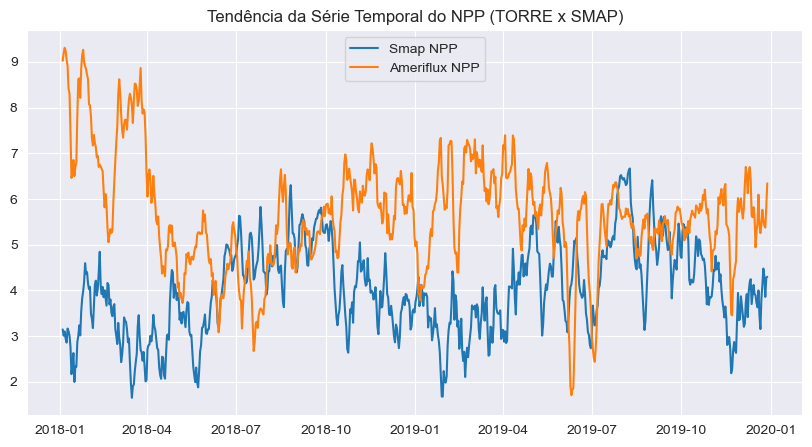

In [20]:
npp_data = pd.concat([(gpp_data[9] - rh_data[9])['2018':'2019'],Npp_ameriflux['Npp']],axis=1).interpolate('time')
npp_data = npp_data.rename({'Npp':'Ameriflux NPP',9:'Smap NPP'},axis=1)

npp_calculado_decomponsicao = seasonal_decompose(npp_data['Smap NPP'])
npp_calculado2_decomponsicao = seasonal_decompose(npp_data['Ameriflux NPP'])

plt.figure(figsize=(10,5))
plt.plot(npp_calculado_decomponsicao.trend)
plt.plot(npp_calculado2_decomponsicao.trend)
plt.title("Tendência da Série Temporal do NPP (TORRE x SMAP)")
plt.legend(['Smap NPP','Ameriflux NPP'],loc='upper center').set_visible(True)

npp_data.corr()

# NEE TORRE X SMAP

,Smap NEE,Ameriflux NEE
Smap NEE,1.000000,0.008837
Ameriflux NEE,0.008837,1.000000


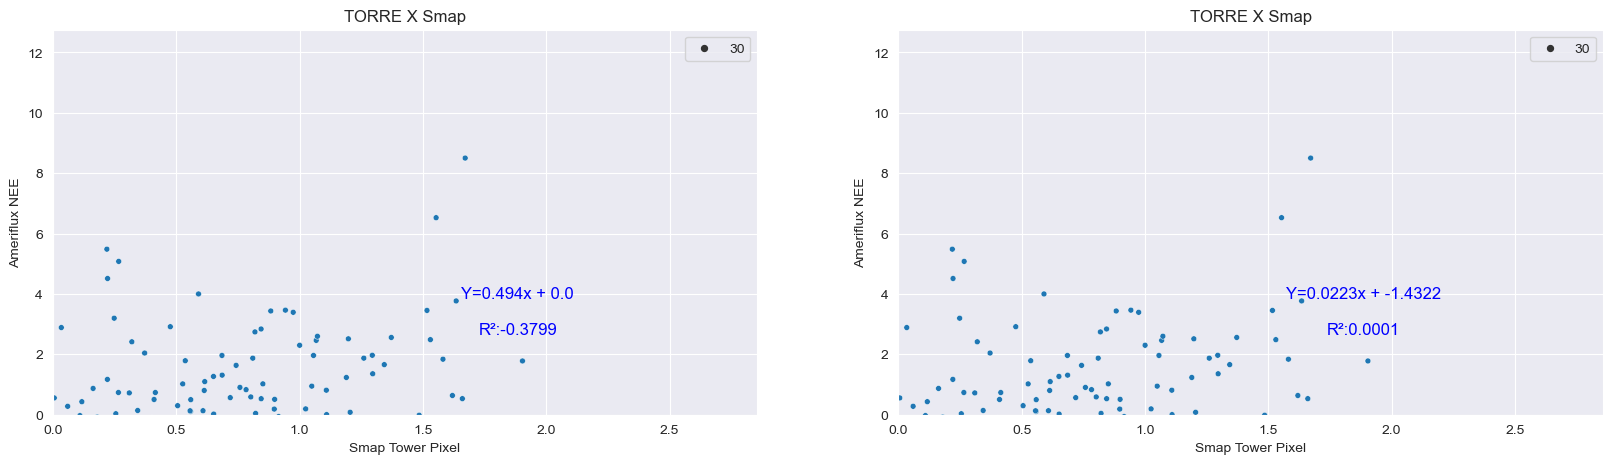

In [22]:
nee_df = pd.concat([nee_data['2018':'2019'][9], nee_ameriflux['Nee']],axis=1).interpolate('time')
nee_df = nee_df.rename({'Nee':'Ameriflux NEE',9:'Smap NEE'},axis=1)


fig, ax = plt.subplots(1,2, figsize=(20, 5))

eixo_x = 'Smap NEE'
eixo_y = 'Ameriflux NEE'

xlabel = 'Smap Tower Pixel'
ylabel = 'Ameriflux NEE'

title = 'TORRE X Smap'

corr = nee_df.corr().copy()

reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=nee_df,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.01,offset_txt_y=4,axes=ax,subplot_num=1,fit_intercept=False)
reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=nee_df,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.01,offset_txt_y=4,axes=ax,subplot_num=2,fit_intercept=True)
corr